In [13]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='.env', verbose=True)

True

In [14]:
import os

BIGQUERY_PROJECT_ID = os.environ.get('BIGQUERY_PROJECT_ID')
BIGQUERY_DATASET = os.environ.get('BIGQUERY_DATASET')
BIGQUERY_DATASET_REGION = os.environ.get('BIGQUERY_DATASET_REGION')
BIGQUERY_TABLE = os.environ.get('BIGQUERY_TABLE')

VERTEXAI_PROJECT_ID = os.environ.get('VERTEXAI_PROJECT_ID')
VERTEXAI_REGION = os.environ.get('VERTEXAI_REGION')

BUCKET_NAME = os.environ.get('BUCKET_NAME')
BUCKET_URI = os.environ.get('BUCKET_URI')
BUCKET_REGION = os.environ.get('BUCKET_REGION')

PREFIX = os.environ.get('PREFIX')

print("BIGQUERY_PROJECT_ID: ",BIGQUERY_PROJECT_ID)
print("BIGQUERY_DATASET: ",BIGQUERY_DATASET)
print("BIGQUERY_DATASET_REGION: ",BIGQUERY_DATASET_REGION)
print("BIGQUERY_TABLE: ",BIGQUERY_TABLE)

print("VERTEXAI_PROJECT_ID: ",VERTEXAI_PROJECT_ID)
print("VERTEXAI_REGION: ",VERTEXAI_REGION)

print("BUCKET_NAME: ",BUCKET_NAME)
print("BUCKET_URI: ",BUCKET_NAME)
print("BUCKET_REGION: ",VERTEXAI_REGION)


PIPELINE_ROOT = 'gs://{}/pipeline_root'.format(BUCKET_NAME)

BIGQUERY_PROJECT_ID:  datafusionsbox
BIGQUERY_DATASET:  dataset4ccc
BIGQUERY_DATASET_REGION:  us
BIGQUERY_TABLE:  df_for_model_ccc_with_weights
VERTEXAI_PROJECT_ID:  datafusionsbox
VERTEXAI_REGION:  us-central1
BUCKET_NAME:  gcp-demo-ccc-vertexai
BUCKET_URI:  gcp-demo-ccc-vertexai
BUCKET_REGION:  us-central1


In [15]:
from google.cloud import aiplatform

aiplatform.init(
    project=VERTEXAI_PROJECT_ID,
    location=VERTEXAI_REGION
)

In [16]:
model_filter_str='labels.experiment_name="'+f"{PREFIX}-experiments"+'"'

models = aiplatform.Model.list(
        filter=model_filter_str
)
    
model = models[0]

In [17]:
input_bq_table_path= f"bq://{BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}"
output_bq_table_prefix=f"bq://{BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}_vertexai"

### Before you start --- input BigQuery table columns must match exactly model input specification!!!!

### Do not run it - it will fail on your table

In [ ]:
batch_prediction_job = model.batch_predict(
    job_display_name=f"{PREFIX}_batch_prediction",
    bigquery_source=input_bq_table_path,
    instances_format="bigquery",
    bigquery_destination_prefix=output_bq_table_prefix,
    predictions_format="bigquery",
    machine_type='n1-standard-4',
    generate_explanation=False,
    sync=False,
)

### To podejscie ma wade taka, ze oczekuje ze identyfikator rekordu jst uzyty jako feature. U nas to nie zadziala - nie bedziemy mogli zidentyfikowac klientow, ktorych model zaklasyfikuje jako rokujacych na tranzakcje. 

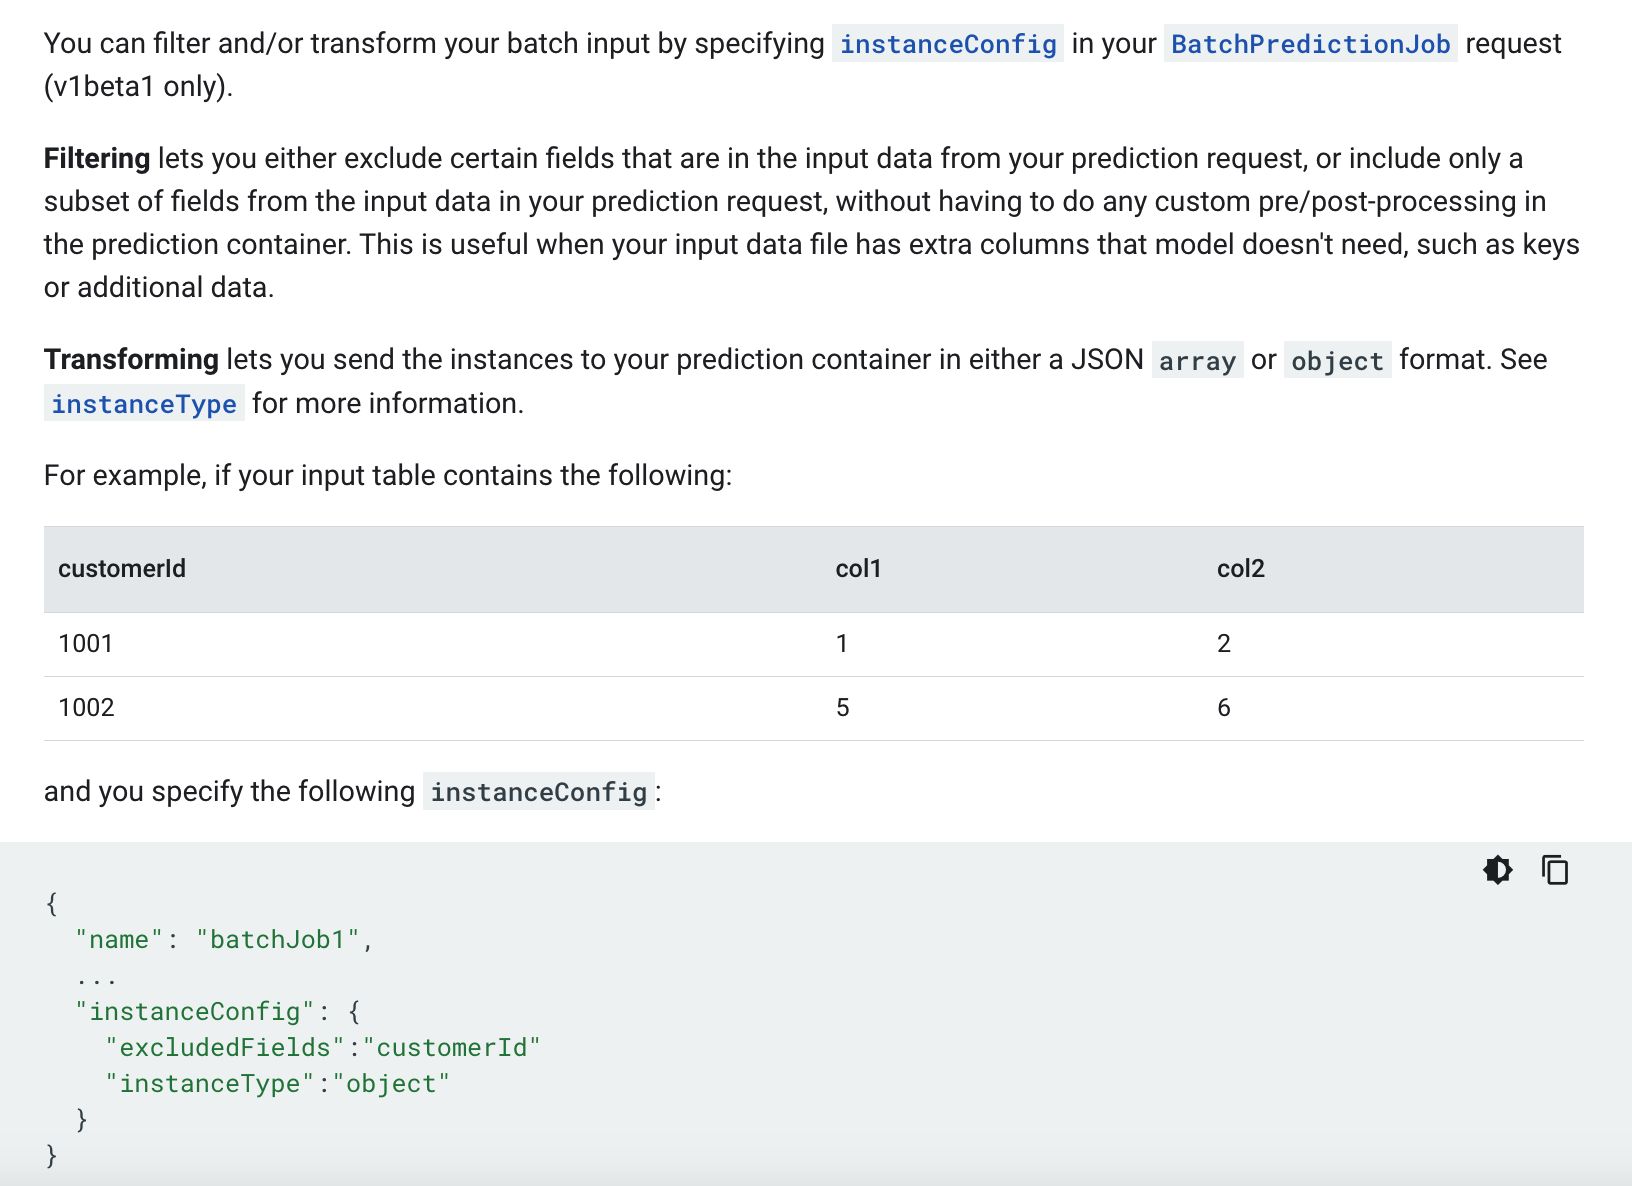

In [18]:
input_bq_table_path= f"bq://{BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}"
output_bq_table_prefix=f"bq://{BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}_vertexai2"


_excluded_columns = ["synerise_client_id", "weight", "y_if_trans"]

In [19]:
from google.cloud import bigquery

table_id = f"{BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}"

client = bigquery.Client()
table = client.get_table(table_id)  # Make an API request.

print(
    "Got table '{}.{}.{}'.".format(table.project, table.dataset_id, table.table_id)
)

Got table 'datafusionsbox.dataset4ccc.df_for_model_ccc_with_weights'.


In [20]:
features = []
for schema_field in table.schema:
    if schema_field.name not in _excluded_columns:
       features.append(schema_field.name)

In [21]:
from google.cloud import aiplatform_v1beta1
client = aiplatform_v1beta1.JobServiceClient()

API_ENDPOINT = "{}-aiplatform.googleapis.com".format(VERTEXAI_REGION)
client_options = {"api_endpoint": API_ENDPOINT}
client = aiplatform_v1beta1.JobServiceClient(client_options=client_options)


# Initialize request argument(s)
## https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1beta1.types.BatchPredictionJob
batch_prediction_job = aiplatform_v1beta1.BatchPredictionJob()
batch_prediction_job.display_name = f"{PREFIX}_batch_prediction_with_projection"
##batch_prediction_job.input_config.gcs_source.uris = ['uris_value1', 'uris_value2']
batch_prediction_job.model=model.resource_name
batch_prediction_job.input_config.bigquery_source.input_uri=input_bq_table_path
batch_prediction_job.input_config.instances_format = "bigquery"
##batch_prediction_job.output_config.gcs_destination.output_uri_prefix = "output_uri_prefix_value"
batch_prediction_job.output_config.bigquery_destination.output_uri=output_bq_table_prefix
batch_prediction_job.output_config.predictions_format = "bigquery"

batch_prediction_job.instance_config.instance_type="array"
batch_prediction_job.instance_config.included_fields=features 

batch_prediction_job.dedicated_resources.machine_spec.machine_type = 'n1-standard-4'
batch_prediction_job.dedicated_resources.starting_replica_count = 1
batch_prediction_job.dedicated_resources.max_replica_count = 1

request = aiplatform_v1beta1.CreateBatchPredictionJobRequest(
        parent=f"projects/{VERTEXAI_PROJECT_ID}/locations/{VERTEXAI_REGION}",
        batch_prediction_job=batch_prediction_job,
)

# Make the request
response = client.create_batch_prediction_job(request=request)

# Handle the response
print(response)

name: "projects/339239659794/locations/us-central1/batchPredictionJobs/2990788862978031616"
display_name: "ccc_batch_prediction_with_projection"
model: "projects/339239659794/locations/us-central1/models/1047599285782183936"
input_config {
  instances_format: "bigquery"
  bigquery_source {
    input_uri: "bq://datafusionsbox.dataset4ccc.df_for_model_ccc_with_weights"
  }
}
output_config {
  predictions_format: "bigquery"
  bigquery_destination {
    output_uri: "bq://datafusionsbox.dataset4ccc.df_for_model_ccc_with_weights_vertexai2"
  }
}
dedicated_resources {
  machine_spec {
    machine_type: "n1-standard-4"
  }
  starting_replica_count: 1
  max_replica_count: 1
}
manual_batch_tuning_parameters {
}
state: JOB_STATE_PENDING
create_time {
  seconds: 1677060249
  nanos: 999816000
}
update_time {
  seconds: 1677060249
  nanos: 999816000
}
instance_config {
  instance_type: "array"
  included_fields: "www_visits_month_freq_1"
  included_fields: "www_visits_month_freq_2"
  included_fields